### Assessment requirements

1. Design an arbitrage strategy on LINK/USDT between Binance and Huobi based on provided data.
2. Code a backtesting program by yourself with Python to test your strategy. Open source backtesting framework is not allowed.
3. Present your backtest result with risk metrics and charts.
4. Submit your risk metrics, charts, trade logs with backtesting Python script.
5. Post trade analysis will be a plus.

* Bar data and orderbook data of a 2 hours period are attached.
* BNC means data from Binance and HB means data from Huobi.
* In bar data file, we only keep 1s bar with trades happened.
* In orderbook data file, a1 means ask1 price, av1 means ask1 volume, b1 means bid1 price and bv1 means bid1 volume.

### 1. Strategy Description

The strategy to capture cross-exchange arbitrage opportunities on the LINK/USDT trading pair  between Binance (BNC) and Huobi (HB) is Buy Low, Sell High simultaneously.

### 2. Data analysis and backtest

#### 2.1 Bar data analysis

Close mean spread: -0.00013, Std: 0.00635, Max: 0.02940, Min: -0.02470
High Spread: count    3079.000000
mean        0.000676
std         0.006134
min        -0.041000
25%        -0.003200
50%         0.000500
75%         0.004100
max         0.055000
Name: spread_high, dtype: float64
Low Spread: count    3079.000000
mean       -0.001008
std         0.005901
min        -0.032400
25%        -0.004800
50%        -0.000900
75%         0.002700
max         0.017400
Name: spread_low, dtype: float64


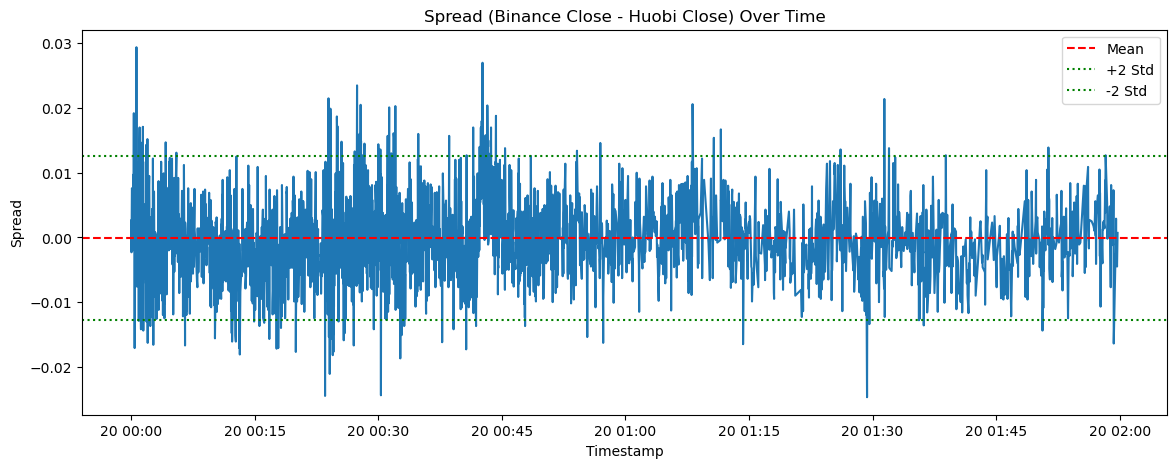

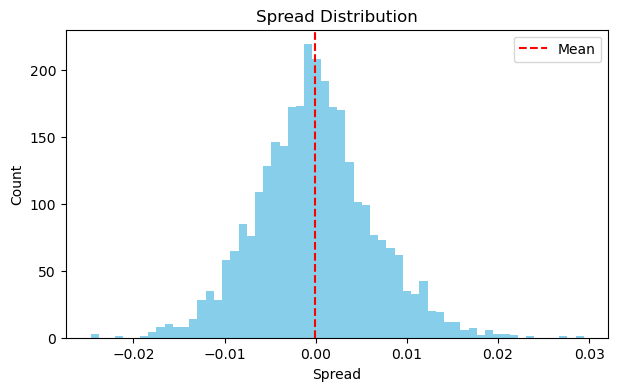

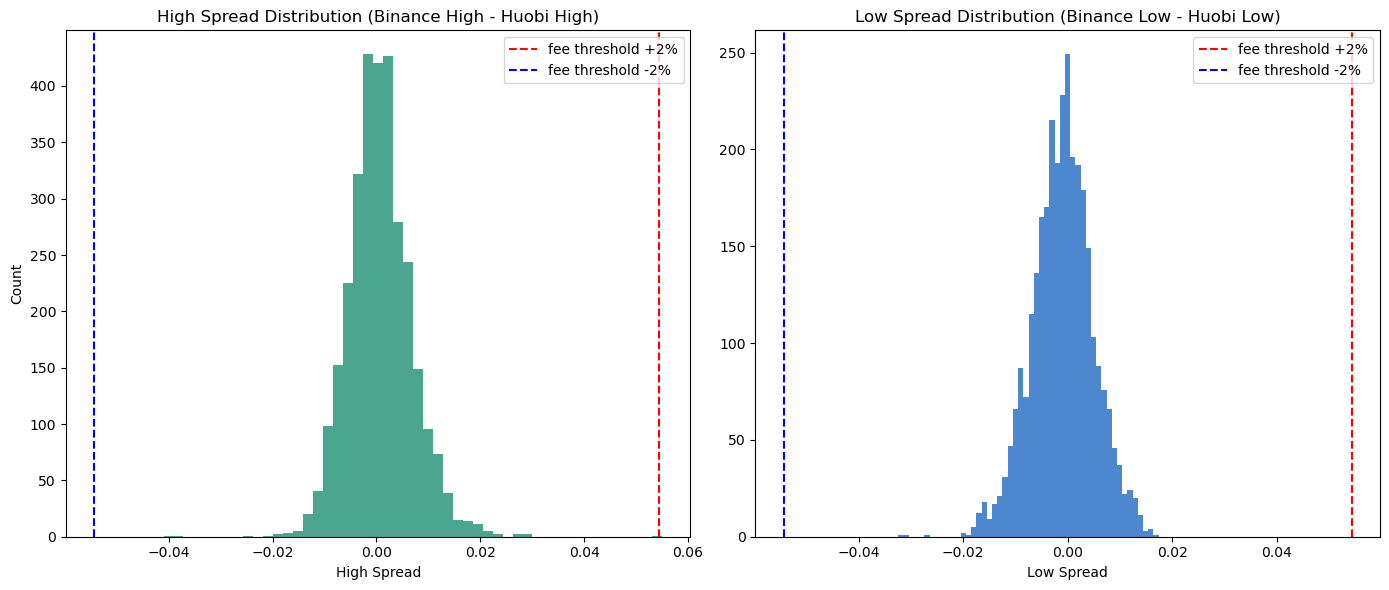

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Load data
bar_bnc = pd.read_csv('bar_bnc.csv', parse_dates=['timestamp'])
bar_hb  = pd.read_csv('bar_hb.csv', parse_dates=['timestamp'])

# 2. Merge
def aggregate_bars(df):
    return df.sort_values('timestamp').groupby('timestamp').agg({
        'open': 'first',
        'high': 'max',
        'low': 'min',
        'close': 'last',
        'volume': 'sum',
        'symbol': 'first' 
    }).reset_index()

bar_bnc_agg = aggregate_bars(bar_bnc)
bar_hb_agg  = aggregate_bars(bar_hb)

bars = pd.merge(bar_bnc_agg, bar_hb_agg, on='timestamp', suffixes=('_bnc', '_hb'))

# 3. Price spread
bars['spread_close'] = bars['close_bnc'] - bars['close_hb']
bars['spread_high']  = bars['high_bnc']  - bars['high_hb']
bars['spread_low']   = bars['low_bnc']   - bars['low_hb']

# 4. Statistic
mean_spread = bars['spread_close'].mean()
std_spread = bars['spread_close'].std()
max_spread = bars['spread_close'].max()
min_spread = bars['spread_close'].min()

print(f"Close mean spread: {mean_spread:.5f}, Std: {std_spread:.5f}, Max: {max_spread:.5f}, Min: {min_spread:.5f}")
print('High Spread:', bars['spread_high'].describe())
print('Low Spread:',  bars['spread_low'].describe())

# 5. Charts
# CLose Spread Line
plt.figure(figsize=(14,5))
plt.plot(bars['timestamp'], bars['spread_close'])
plt.axhline(mean_spread, color='red', linestyle='--', label='Mean')
plt.axhline(mean_spread + 2*std_spread, color='green', linestyle=':', label='+2 Std')
plt.axhline(mean_spread - 2*std_spread, color='green', linestyle=':', label='-2 Std')
plt.title('Spread (Binance Close - Huobi Close) Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Spread')
plt.legend()
plt.show()

# Close Spread Hist
plt.figure(figsize=(7,4))
plt.hist(bars['spread_close'], bins=60, color='skyblue')
plt.axvline(mean_spread, color='red', linestyle='--', label='Mean')
plt.title('Spread Distribution')
plt.xlabel('Spread')
plt.ylabel('Count')
plt.legend()
plt.show()

fee = bars['close_bnc'].mean()*0.001*2
plt.figure(figsize=(14,6))

# High Spread Hist
plt.subplot(1,2,1)
plt.hist(bars['spread_high'], bins=50, color='#008060', alpha=0.7)
plt.axvline(fee, color='red', linestyle='--', label='fee threshold +2%')
plt.axvline(-fee, color='blue', linestyle='--', label='fee threshold -2%')
plt.title('High Spread Distribution (Binance High - Huobi High)')
plt.xlabel('High Spread')
plt.ylabel('Count')
plt.legend()

# Low Spread Hist
plt.subplot(1,2,2)
plt.hist(bars['spread_low'], bins=50, color='#0055bb', alpha=0.7)
plt.axvline(fee, color='red', linestyle='--', label='fee threshold +2%')
plt.axvline(-fee, color='blue', linestyle='--', label='fee threshold -2%')
plt.title('Low Spread Distribution (Binance Low - Huobi Low)')
plt.xlabel('Low Spread')
plt.legend()
plt.tight_layout()
plt.show()

- The observed price spreads (close, high, low) are generally much smaller than the standard transaction fees (e.g., 0.1% per trade)
- Occasional larger spreads (max ±4–5 cents) suggest opportunities may arise during volatility spikes, news events, or liquidity gaps.

Next step: analyze order book snapshots

#### 2.2 Orderbook data analysis and backtest

In [10]:
# Load data
ob_bnc = pd.read_csv('orderbook_bnc.csv', parse_dates=['timestamp'])
ob_hb  = pd.read_csv('orderbook_hb.csv', parse_dates=['timestamp'])

# Only keep the last snapshot per second per exchange. In post analysis we need to report possibility to optimize data merge
ob_bnc = ob_bnc.sort_values('timestamp').groupby('timestamp').tail(1).reset_index(drop=True)
ob_hb  = ob_hb.sort_values('timestamp').groupby('timestamp').tail(1).reset_index(drop=True)

merged = pd.merge(ob_bnc, ob_hb, on='timestamp', suffixes=('_bnc', '_hb'))
print('Merged rows:', len(merged))

Merged rows: 7200


In [11]:
def simulate_arbitrage_for_fee(merged, fee, max_levels=10, return_log=False):
    trade_log = []
    for idx, row in merged.iterrows():
        # HB->BNC
        h_asks = np.array([row[f'a{i}_hb'] for i in range(1, max_levels+1)])
        h_avs = np.array([row[f'av{i}_hb'] for i in range(1, max_levels+1)])
        b_bids = np.array([row[f'b{i}_bnc'] for i in range(1, max_levels+1)])
        b_bvs = np.array([row[f'bv{i}_bnc'] for i in range(1, max_levels+1)])
        h_idx, b_idx = 0, 0
        while h_idx < max_levels and b_idx < max_levels:
            buy_price  = h_asks[h_idx]
            buy_avail  = h_avs[h_idx]
            sell_price = b_bids[b_idx]
            sell_avail = b_bvs[b_idx]
            spread = sell_price - buy_price
            threshold = buy_price * fee + sell_price * fee
            if spread > threshold:
                amt = min(buy_avail, sell_avail)
                profit = (spread - threshold) * amt
                if return_log:
                    trade_log.append({
                        'timestamp': row['timestamp'],
                        'direction': 'HB->BNC',
                        'buy_exchange': 'HB',
                        'sell_exchange': 'BNC',
                        'buy_price': float(buy_price),
                        'sell_price': float(sell_price),
                        'amount': float(amt),
                        'profit': float(profit),
                        'fee': float(threshold)*float(amt),
                        'spread': float(spread),
                    })
                else:
                    trade_log.append(profit)
                h_avs[h_idx] -= amt
                b_bvs[b_idx] -= amt
                if h_avs[h_idx] == 0: h_idx += 1
                if b_bvs[b_idx] == 0: b_idx += 1
            else:
                break
        # BNC->HB
        b_asks = np.array([row[f'a{i}_bnc'] for i in range(1, max_levels+1)])
        b_avs = np.array([row[f'av{i}_bnc'] for i in range(1, max_levels+1)])
        h_bids = np.array([row[f'b{i}_hb'] for i in range(1, max_levels+1)])
        h_bvs = np.array([row[f'bv{i}_hb'] for i in range(1, max_levels+1)])
        b_idx, h_idx = 0, 0
        while b_idx < max_levels and h_idx < max_levels:
            buy_price  = b_asks[b_idx]
            buy_avail  = b_avs[b_idx]
            sell_price = h_bids[h_idx]
            sell_avail = h_bvs[h_idx]
            spread = sell_price - buy_price
            threshold = buy_price * fee + sell_price * fee
            if spread > threshold:
                amt = min(buy_avail, sell_avail)
                profit = (spread - threshold) * amt
                if return_log:
                    trade_log.append({
                        'timestamp': row['timestamp'],
                        'direction': 'BNC->HB',
                        'buy_exchange': 'BNC',
                        'sell_exchange': 'HB',
                        'buy_price': float(buy_price),
                        'sell_price': float(sell_price),
                        'amount': float(amt),
                        'profit': float(profit),
                        'fee': float(threshold)*float(amt),
                        'spread': float(spread),
                    })
                else:
                    trade_log.append(profit)
                b_avs[b_idx] -= amt
                h_bvs[h_idx] -= amt
                if b_avs[b_idx] == 0: b_idx += 1
                if h_bvs[h_idx] == 0: h_idx += 1
            else:
                break
    if return_log:
        return trade_log
    else:
        total_profit = np.sum(trade_log)
        return total_profit, len(trade_log)


### 3. Backtest result with risk metrics and charts. (backtesting when fee = 0.01% per side)

Arbitrage Backtest Result (fee=0.01%)
Total Arbitrage Profit   :    30.6762 USDT
Total Arbitrage Trades   :        190
Mean Profit/Trade        :     0.1615 USDT
Median Profit/Trade      :     0.0469 USDT
Max Profit/Trade         :     2.2623 USDT
Min Profit/Trade         :     0.0000 USDT
Std. Profit/Trade        :     0.3258 USDT
Sharpe Ratio             :     6.8314
Max Drawdown             :     0.0000 USDT
Win Rate                 :    100.00%


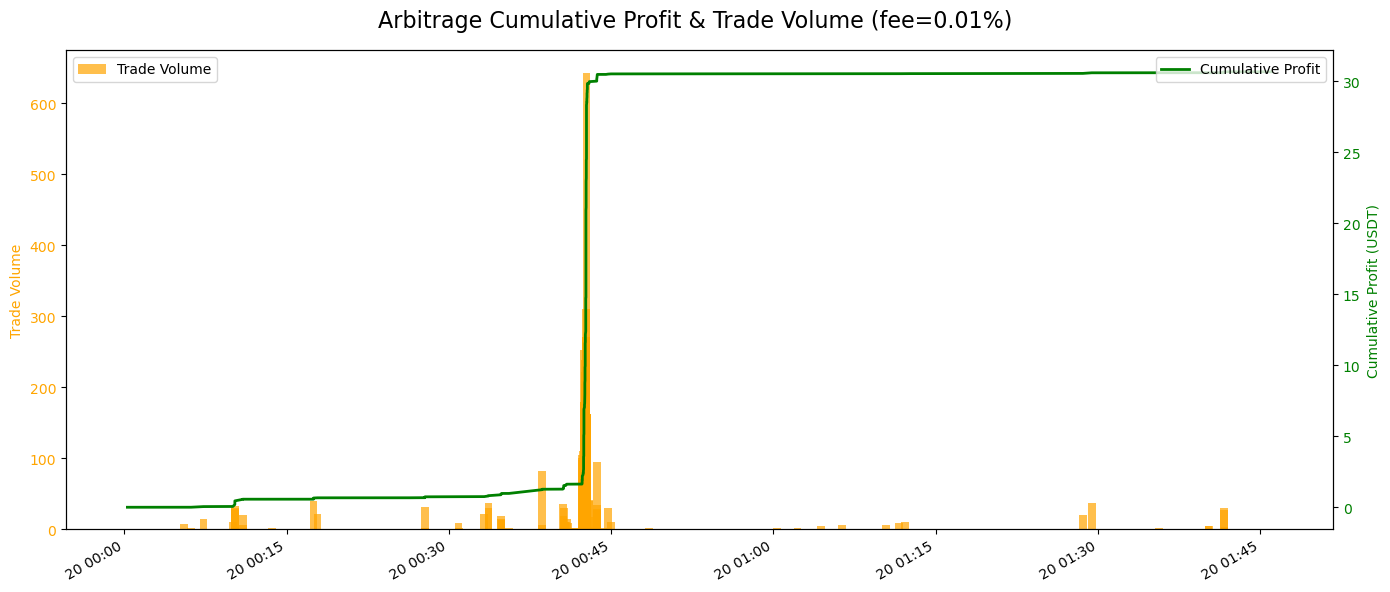

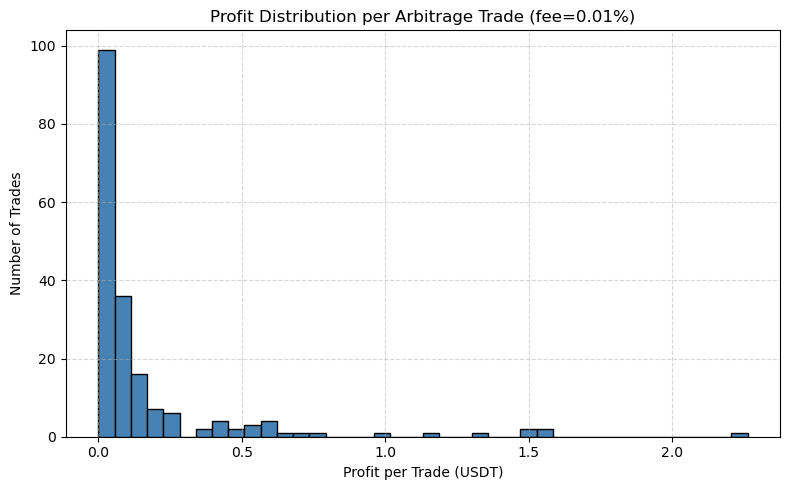

In [13]:
fee_for_detail = 0.0001
trade_log = simulate_arbitrage_for_fee(merged, fee_for_detail, return_log=True)
trade_df = pd.DataFrame(trade_log)

if not trade_df.empty:
    trade_df = trade_df.sort_values('timestamp')
    trade_df['cum_profit'] = trade_df['profit'].cumsum()

    total_profit = trade_df['profit'].sum()
    opp_count = len(trade_df)
    mean_profit = trade_df['profit'].mean()
    median_profit = trade_df['profit'].median()
    max_profit = trade_df['profit'].max()
    min_profit = trade_df['profit'].min()
    std_profit = trade_df['profit'].std()

    # Sharpe Ratio: suppose risk-free rate = 0
    sharpe = mean_profit / std_profit * np.sqrt(opp_count) if std_profit > 0 else np.nan

    # Max Drawdown
    cum_profit = trade_df['cum_profit']
    running_max = np.maximum.accumulate(cum_profit)
    drawdown = running_max - cum_profit
    max_drawdown = drawdown.max()

    # Win Rate
    win_rate = (trade_df['profit'] > 0).mean()

    print("="*40)
    print("Arbitrage Backtest Result (fee=0.01%)")
    print("="*40)
    print(f"{'Total Arbitrage Profit':<25}: {total_profit:10.4f} USDT")
    print(f"{'Total Arbitrage Trades':<25}: {opp_count:10d}")
    print(f"{'Mean Profit/Trade':<25}: {mean_profit:10.4f} USDT")
    print(f"{'Median Profit/Trade':<25}: {median_profit:10.4f} USDT")
    print(f"{'Max Profit/Trade':<25}: {max_profit:10.4f} USDT")
    print(f"{'Min Profit/Trade':<25}: {min_profit:10.4f} USDT")
    print(f"{'Std. Profit/Trade':<25}: {std_profit:10.4f} USDT")
    print(f"{'Sharpe Ratio':<25}: {sharpe:10.4f}")
    print(f"{'Max Drawdown':<25}: {max_drawdown:10.4f} USDT")
    print(f"{'Win Rate':<25}: {win_rate:10.2%}")
    print("="*40)

    fig, ax1 = plt.subplots(figsize=(14,6))
    ax1.bar(trade_df['timestamp'], trade_df['amount'], width=0.0005, alpha=0.7, color='orange', label='Trade Volume')
    ax1.set_ylabel('Trade Volume', color='orange')
    ax1.tick_params(axis='y', labelcolor='orange')
    ax2 = ax1.twinx()
    ax2.plot(trade_df['timestamp'], trade_df['cum_profit'], color='green', linewidth=2, label='Cumulative Profit')
    ax2.set_ylabel('Cumulative Profit (USDT)', color='green')
    ax2.tick_params(axis='y', labelcolor='green')
    fig.suptitle('Arbitrage Cumulative Profit & Trade Volume (fee=0.01%)', fontsize=16)
    fig.autofmt_xdate()
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

    # Profit distribution
    plt.figure(figsize=(8,5))
    plt.hist(trade_df['profit'], bins=40, color='steelblue', edgecolor='black')
    plt.title('Profit Distribution per Arbitrage Trade (fee=0.01%)')
    plt.xlabel('Profit per Trade (USDT)')
    plt.ylabel('Number of Trades')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

    # export to csv
    trade_df.to_csv('arbitrage_trade_log.csv', index=False)
else:
    print("No arbitrage opportunity found at fee = 0.01%.")


The arbitrage strategy is consistently profitable in a low-risk way, but the margins are thin.

Most trades yield small profits; only a few trades capture significantly higher profits, so the trading fees is quite important for this strategy.

Let`s analyze how the trading fee impacts the strategy.

#### Trading fee impacts on profits

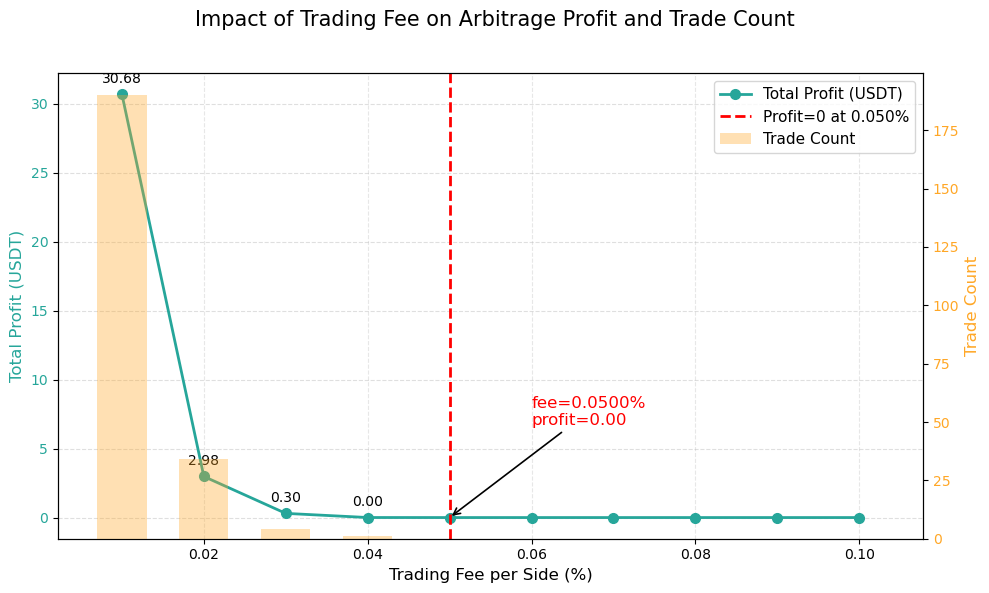

In [16]:
fees = np.arange(0.0001, 0.0011, 0.0001) # 0.01%~0.11%, step = 0.01%
profits = []
trade_counts = []
# Run simulation for each fee and record results
for fee in fees:
    p, c = simulate_arbitrage_for_fee(merged, fee)
    profits.append(p)
    trade_counts.append(c)
profits = np.array(profits)
trade_counts = np.array(trade_counts)

# Find the first fee where profit drops to zero or below
zero_idx = np.where(profits <= 0)[0]
fee_zero = fees[zero_idx[0]] if len(zero_idx) > 0 else None
profit_zero = profits[zero_idx[0]] if len(zero_idx) > 0 else None

fig, ax1 = plt.subplots(figsize=(10, 6))

# Line plot for total profit
ax1.plot(fees * 100, profits, color='#26A69A', marker='o', markersize=7, lw=2, label='Total Profit (USDT)')
ax1.set_xlabel('Trading Fee per Side (%)', fontsize=12)
ax1.set_ylabel('Total Profit (USDT)', color='#26A69A', fontsize=12)
ax1.tick_params(axis='y', labelcolor='#26A69A')
ax1.yaxis.grid(True, which='major', linestyle='--', alpha=0.4)
ax1.xaxis.grid(True, which='major', linestyle='--', alpha=0.3)

# Bar plot for trade count
ax2 = ax1.twinx()
ax2.bar(fees * 100, trade_counts, width=0.006, color='#FFA726', alpha=0.35, label='Trade Count', zorder=1)
ax2.set_ylabel('Trade Count', color='#FFA726', fontsize=12)
ax2.tick_params(axis='y', labelcolor='#FFA726')

# Annotate profit for each fee where there is at least one trade
for i, (fee, profit, count) in enumerate(zip(fees, profits, trade_counts)):
    if count > 0:
        ax1.annotate(
            f'{profit:.2f}',
            (fee * 100, profit),
            textcoords="offset points",
            xytext=(0, 8),
            ha='center',
            fontsize=10,
            color='black'
        )

# Annotate the point where profit reaches zero
if fee_zero is not None:
    ax1.axvline(fee_zero * 100, color='red', linestyle='--', lw=2, label=f'Profit=0 at {fee_zero*100:.3f}%')
    ax1.annotate(
        f'fee={fee_zero*100:.4f}%\nprofit={profit_zero:.2f}',
        xy=(fee_zero * 100, profit_zero),
        xytext=(fee_zero * 100 + 0.01, profits.max() * 0.25),
        arrowprops=dict(facecolor='red', arrowstyle='->', lw=1.2),
        fontsize=12, color='red', ha='left', va='center'
    )

# Combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right', fontsize=11, frameon=True)

fig.suptitle('Impact of Trading Fee on Arbitrage Profit and Trade Count', fontsize=15)
plt.tight_layout(rect=[0,0,1,0.96])
plt.show()

- When fee in per side >= 0.05%, there will be no room for ptofit.

### 5. Post trade analysis

#### 5.1 Orderbook data merge

I only keep the last order book snapshot per second for data merging and analysis. 
While this simplifies the processing, it may miss short-lived arbitrage opportunities that occur within each second and does not accurately capture execution latency or order matching dynamics. 

In the future, retaining all high-frequency snapshots, using finer-grained time (ms level) alignment would improve the accuracy and practical relevance of the backtest results.

#### 5.2 Directional performance & Capital allocation analysis


Directional Performance Summary:
direction  trades total_profit mean_profit_per_trade median_profit_per_trade
  BNC->HB      44       1.1273                0.0256                  0.0029
  HB->BNC     146      29.5488                0.2024                  0.0794


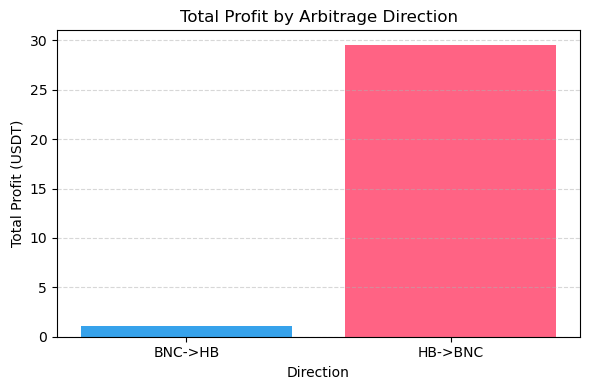

In [22]:
# Group by direction and compute stats
direction_stats = trade_df.groupby('direction').agg(
    trades=('profit', 'count'),
    total_profit=('profit', 'sum'),
    mean_profit_per_trade=('profit', 'mean'),
    median_profit_per_trade=('profit', 'median')
).reset_index()

# Print results as a formatted table
print("\nDirectional Performance Summary:")
print(direction_stats.to_string(index=False, 
    formatters={
        'total_profit': '{:.4f}'.format,
        'mean_profit_per_trade': '{:.4f}'.format,
        'median_profit_per_trade': '{:.4f}'.format
    }
))

# Bar plot: profit by direction
plt.figure(figsize=(6,4))
plt.bar(direction_stats['direction'], direction_stats['total_profit'], color=['#36a2eb','#ff6384'])
plt.title('Total Profit by Arbitrage Direction')
plt.xlabel('Direction')
plt.ylabel('Total Profit (USDT)')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Most arbitrage opportunities and profit were from buying on Huobi and selling on Binance. The reverse direction (BNC→HB) was far less profitable and less frequent, possibly due to tighter spreads or less available liquidity on that leg.

In [24]:
max_amt_bnc = trade_df[trade_df['direction'] == 'BNC->HB']['amount'].max()
max_amt_hb  = trade_df[trade_df['direction'] == 'HB->BNC']['amount'].max()

print(f"Max amount needed on Binance (for BNC->HB): {max_amt_bnc:.4f} LINK")
print(f"Max amount needed on Huobi (for HB->BNC): {max_amt_hb:.4f} LINK")

direction_ratio = trade_df.groupby('direction')['profit'].sum()
allocation = direction_ratio / direction_ratio.sum()

print("\nRecommended capital allocation based on total profit per direction:")
for direction, ratio in allocation.items():
    print(f"  {direction}: {ratio:.2%} of total capital")

trade_df['timestamp'] = pd.to_datetime(trade_df['timestamp'])
trade_df = trade_df.sort_values('timestamp')
window = '30S' 

max_bnc = trade_df[trade_df['direction']=='BNC->HB'].set_index('timestamp')['amount'].rolling(window).sum().max()
max_hb  = trade_df[trade_df['direction']=='HB->BNC'].set_index('timestamp')['amount'].rolling(window).sum().max()

print(f"\nRecommended initial capital for Binance (BNC->HB, 30s peak): {max_bnc:.2f} LINK")
print(f"Recommended initial capital for Huobi (HB->BNC, 30s peak): {max_hb:.2f} LINK")

Max amount needed on Binance (for BNC->HB): 39.7500 LINK
Max amount needed on Huobi (for HB->BNC): 642.8590 LINK

Recommended capital allocation based on total profit per direction:
  BNC->HB: 3.67% of total capital
  HB->BNC: 96.33% of total capital

Recommended initial capital for Binance (BNC->HB, 30s peak): 139.31 LINK
Recommended initial capital for Huobi (HB->BNC, 30s peak): 8900.83 LINK


/var/folders/ds/mkh4v64x4nj4bdy675p3s3mh0000gn/T/ipykernel_39182/578802819.py:18: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  max_bnc = trade_df[trade_df['direction']=='BNC->HB'].set_index('timestamp')['amount'].rolling(window).sum().max()
/var/folders/ds/mkh4v64x4nj4bdy675p3s3mh0000gn/T/ipykernel_39182/578802819.py:19: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  max_hb  = trade_df[trade_df['direction']=='HB->BNC'].set_index('timestamp')['amount'].rolling(window).sum().max()


- Initial Capital Analysis:

The backtest results indicate that during peak 30-second intervals, the required working capital for each exchange is much higher than the maximum single trade amount:

Binance: 139.31 LINK (BNC→HB direction)

Huobi: 8,900.83 LINK (HB→BNC direction)

To avoid missing any arbitrage opportunities due to insufficient funds during high-frequency trading periods, a significantly larger capital pool is necessary.

- This allocation is based on historical profit concentration and may need to be updated as market conditions change. For real trading, we need sufficient buffer for each side to handle volume spikes and operational risk.

#### 5.3 Profit Concentration Analysis

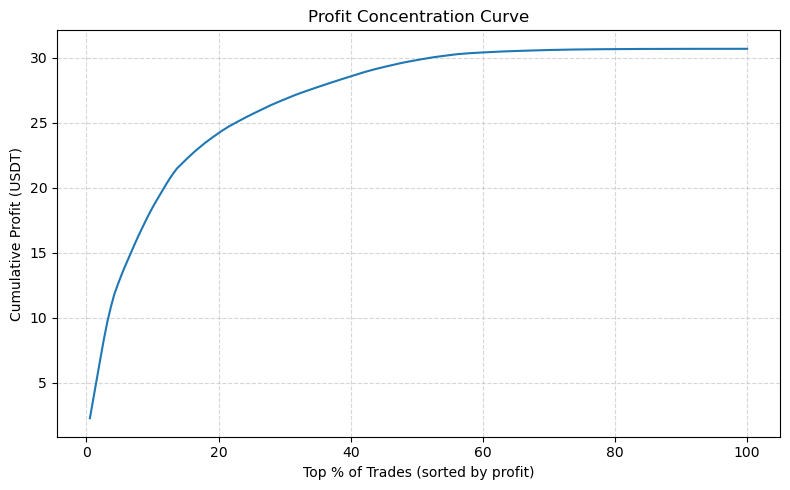

High Concentration:
  Top 5% of trades generated 43.1% of profits
  Top 20% generated 78.9% of profits
  Top 50% generated 97.2% of profits

Inefficient Trades:
  Bottom 50% of trades contributed 2.8% of profits
  28 trades had profits < $0.001


In [27]:
# Sort trades by profit descending
trade_df_sorted = trade_df.sort_values('profit', ascending=False).reset_index(drop=True)
trade_df_sorted['cum_profit'] = trade_df_sorted['profit'].cumsum()
total_profit = trade_df_sorted['profit'].sum()

# Calculate thresholds
n = len(trade_df_sorted)
pcts = [0.05, 0.2, 0.5]  # 5%, 20%, 50%
contribs = {}

for pct in pcts:
    top_n = int(np.ceil(pct * n))
    profit_contrib = trade_df_sorted.iloc[:top_n]['profit'].sum() / total_profit * 100
    contribs[pct] = profit_contrib

# Inefficient trades: very small profits
small_trade_count = (trade_df_sorted['profit'] < 0.001).sum()
small_trade_pct = small_trade_count / n * 100

# Cumulative profit curve
plt.figure(figsize=(8,5))
plt.plot(np.arange(1, n+1) / n * 100, trade_df_sorted['cum_profit'], label='Cumulative Profit')
plt.xlabel('Top % of Trades (sorted by profit)')
plt.ylabel('Cumulative Profit (USDT)')
plt.title('Profit Concentration Curve')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Print summary
print(f"High Concentration:")
print(f"  Top 5% of trades generated {contribs[0.05]:.1f}% of profits")
print(f"  Top 20% generated {contribs[0.2]:.1f}% of profits")
print(f"  Top 50% generated {contribs[0.5]:.1f}% of profits")
print()
print(f"Inefficient Trades:")
print(f"  Bottom 50% of trades contributed {100-contribs[0.5]:.1f}% of profits")
print(f"  {small_trade_count} trades had profits < $0.001")

- To improve overall efficiency and reduce operational costs, consider implementing a minimum profit threshold (e.g., $0.005 per trade) to filter out low-value and potentially inefficient trades.

#### 5.4 Cost analysis

#### a. Trading fees play a crucial role in arbitrage profitability.
As the per-side trading fee increases, arbitrage profits decrease significantly. When the fee per side reaches or exceeds 0.05%, arbitrage opportunities are effectively eliminated, and no profitable trades remain.
#### b. Exchange-imposed minimum fees can further reduce or eliminate arbitrage opportunities.
Even if calculated fees seem low, many exchanges enforce a minimum fee per trade. If the profit per trade is smaller than the minimum fee, those trades will not be profitable in practice.
#### c. Slippage: Executed prices may be worse than quoted order book levels, especially for large volumes.

#### 5.5 Arbitrage opportunity frequency analysis

/var/folders/ds/mkh4v64x4nj4bdy675p3s3mh0000gn/T/ipykernel_39182/3570476576.py:1: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  trade_df['second'] = trade_df['timestamp'].dt.floor('S')


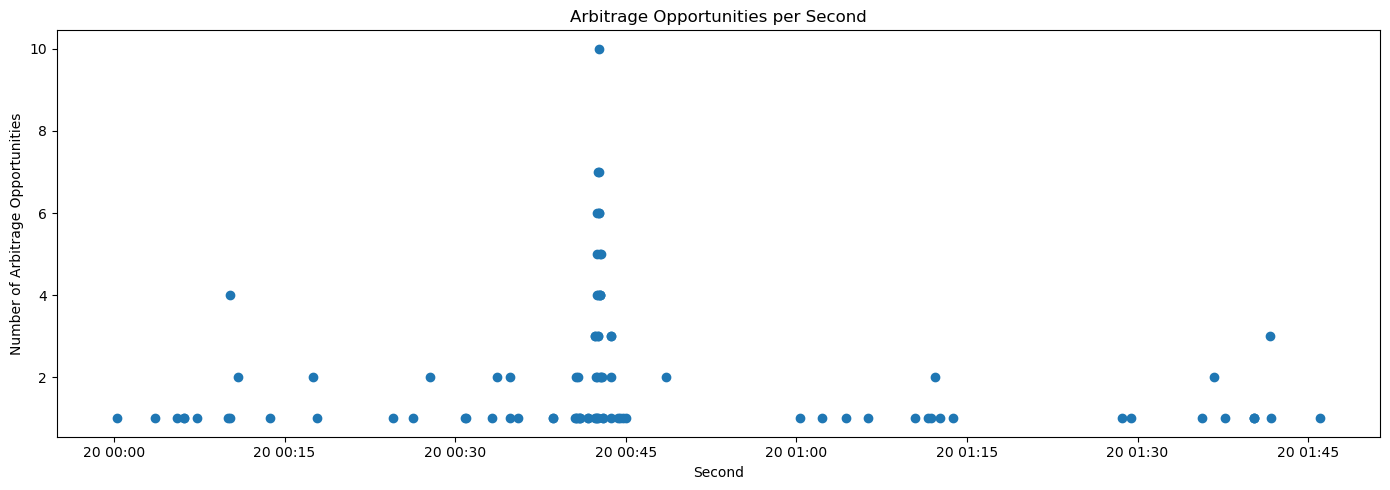

Total number of unique minutes with arbitrage: 38
Max opportunities in a single minute: 105
Median opportunities per minute: 1.5
Number of minutes with >3 opportunities: 6


/var/folders/ds/mkh4v64x4nj4bdy675p3s3mh0000gn/T/ipykernel_39182/3570476576.py:11: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  trade_df['minute'] = trade_df['timestamp'].dt.floor('T')


In [32]:
trade_df['second'] = trade_df['timestamp'].dt.floor('S')
opps_per_second = trade_df.groupby('second').size()
plt.figure(figsize=(14,5))
plt.plot(opps_per_second.index, opps_per_second.values, marker='o', linestyle='None')
plt.xlabel('Second')
plt.ylabel('Number of Arbitrage Opportunities')
plt.title('Arbitrage Opportunities per Second')
plt.tight_layout()
plt.show()

trade_df['minute'] = trade_df['timestamp'].dt.floor('T')
opps_per_minute = trade_df.groupby('minute').size()
print("Total number of unique minutes with arbitrage:", opps_per_minute.count())
print("Max opportunities in a single minute:", opps_per_minute.max())
print("Median opportunities per minute:", opps_per_minute.median())
print("Number of minutes with >3 opportunities:", (opps_per_minute > 3).sum())


Opportunities are highly clustered in specific periods rather than uniformly distributed. While the typical active minute had just 1–2 opportunities, a small number of minutes (6 out of 38) saw more frequent activity, with one minute experiencing as many as 105 opportunities.
This highlights that most arbitrage potential arises in short, intense bursts—implying that a highly responsive, automated strategy is necessary to capture value, especially during brief market dislocations.